In [1]:
import functools
import os
import concurrent.futures

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import smatch
import healsparse

In [3]:
import lib

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"

In [5]:
from scipy.ndimage import gaussian_filter


def get_bin_centers(bins):
    return 0.5 * (bins[:-1] + bins[1:])


def contour1d(axs, data, bins, *, smoothing=1, **kwargs):
    bin_centers = get_bin_centers(bins)
    lines = axs.plot(
        bin_centers,
        gaussian_filter(data, sigma=smoothing),
        **kwargs
    )

    return lines

In [6]:
def watermark(
    fig,
    text="preliminary",
):
    fig_width, fig_height = fig.get_size_inches()
    angle = np.degrees(np.arctan2(fig_height, fig_width))
    size = np.hypot(fig_width, fig_height) * 6 
    fig.text(
        0.5,
        0.5,
        text,
        color="k",
        alpha=0.1,
        fontsize=size,
        rotation=angle,
        horizontalalignment="center",
        verticalalignment="center",
    )

    return None

In [7]:
shear_step = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [8]:
redshift_sim = h5py.File(
    os.path.join(
        "/global/cfs/cdirs/des/boyan/sompz_output/y6_imsim_1000Tile/",
        shear_step,
        "noshear/weighted_pile3_oldtomo/sompz_y6_sim_noshear_1000Tile.hdf5",
    )
)

In [9]:
shear_sim = h5py.File(
    lib.const.IMSIM_CATALOGS[shear_step],
)

In [10]:
truth_match = h5py.File(
    lib.const.MATCH_CATALOGS[shear_step],
)

In [11]:
_, shear_sim_index, redshift_sim_index = np.intersect1d(
    shear_sim["mdet/noshear"]["uid"],
    redshift_sim["catalog/sompz/noshear"]["coadd_object_id"],
    return_indices=True,
)

In [12]:
np.testing.assert_equal(
    shear_sim["mdet/noshear"]["uid"][:][shear_sim_index],
    redshift_sim["catalog/sompz/noshear"]["coadd_object_id"][:][redshift_sim_index],
)

In [13]:
bhat_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
bhat_sim[shear_sim_index] = redshift_sim["catalog/sompz/noshear"]["bhat"][:][redshift_sim_index]

In [14]:
cell_sim = np.full(shear_sim["mdet/noshear"]["uid"].shape, np.nan)
cell_sim[shear_sim_index] = redshift_sim["catalog/sompz/noshear"]["cell_wide"][:][redshift_sim_index]

In [15]:
weights_sim = lib.weights.get_shear_weights(shear_sim["mdet/noshear"])

In [16]:
count_grid_sim, _, _ = stats.binned_statistic(
    cell_sim,
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)
occupancy_grid_sim = count_grid_sim / sum(count_grid_sim)

In [17]:
_weight_grid_sim, _, _ = stats.binned_statistic(
    cell_sim,
    weights_sim,
    statistic="sum",
    bins=lib.const.CELL_IDS,
)
weight_grid_sim = _weight_grid_sim / sum(_weight_grid_sim)

In [18]:
cell_assignments_sim = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments_sim[tomographic_bin] = np.unique(
        cell_sim[bhat_sim == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments_sim.values()
        ],
    )
) == 0

---

In [19]:
shear_y6 = h5py.File(lib.const.Y6_SHEAR_CATALOG)
redshift_y6 = h5py.File(lib.const.Y6_REDSHIFT_CATALOG)

In [20]:
_, shear_y6_index, redshift_y6_index = np.intersect1d(
    shear_y6["mdet/noshear"]["uid"],
    redshift_y6["sompz/noshear"]["coadd_object_id"],
    return_indices=True,
)

In [21]:
bhat_y6 = np.full(shear_y6["mdet/noshear"]["uid"].shape, np.nan)
bhat_y6[shear_y6_index] = redshift_y6["sompz/noshear"]["bhat"][:][redshift_y6_index]

In [22]:
cell_y6 = np.full(shear_y6["mdet/noshear"]["uid"].shape, np.nan)
cell_y6[shear_y6_index] = redshift_y6["sompz/noshear"]["cell_wide"][:][redshift_y6_index]

In [23]:
weights_y6 = lib.weights.get_shear_weights(shear_y6["mdet/noshear"])

In [24]:
count_grid_y6, _, _ = stats.binned_statistic(
    cell_y6,
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)
occupancy_grid_y6 = count_grid_y6 / sum(count_grid_y6)

In [25]:
_weight_grid_y6, _, _ = stats.binned_statistic(
    cell_y6,
    weights_y6,
    statistic="sum",
    bins=lib.const.CELL_IDS,
)
weight_grid_y6 = _weight_grid_y6 / sum(_weight_grid_y6)

In [26]:
cell_assignments_y6 = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments_y6[tomographic_bin] = np.unique(
        cell_y6[bhat_y6 == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments_y6.values()
        ],
    )
) == 0

---

In [27]:
tilenames = np.unique(shear_sim["mdet/noshear"]["tilename"][:].astype(str))

In [28]:
mdet_mask = lib.util.load_mdet_mask()
mdet_area = mdet_mask.get_valid_area()

In [29]:
def accumulate_area(tile, mdet_mask):
    tile_area = lib.util.get_tile_area(
        tile,
        "r",
        shear="plus",
        mdet_mask=mdet_mask,
    )

    return tile_area

In [30]:
def accumulate_hist(shear, bhat, bins, tomographic_bin=None, tile=None):
    # plus
    in_tile = shear["mdet/noshear"]["tilename"][:].astype(str) == tile
    in_tomo = bhat == tomographic_bin
    sel = in_tile & in_tomo

    matcher = smatch.Matcher(shear["mdet/noshear"]["ra"][sel], shear["mdet/noshear"]["dec"][sel])
    indices, distances = matcher.query_knn(matcher.lon, matcher.lat, k=2, return_distances=True)
    dnn = distances[:, 1] * 60 * 60
    del matcher, indices, distances

    hist, _ = np.histogram(dnn, bins=bins)
    del dnn

    return hist

In [31]:
def accumulate_hist_rand(shear, bhat, bins, mdet_mask, tomographic_bin=None, tile=None):
    # plus
    in_tile = shear["mdet/noshear"]["tilename"][:].astype(str) == tile
    in_tomo = bhat == tomographic_bin
    sel = in_tile & in_tomo

    tile_map = lib.util.get_tile_mask(
        tile,
        "r",
        shear="plus",
        mdet_mask=mdet_mask,
    )

    n_sample = np.sum(sel)

    rand_ra, rand_dec = healsparse.make_uniform_randoms(tile_map, n_sample)
    del tile_map

    rand_matcher = smatch.Matcher(rand_ra, rand_dec)
    rand_indices, rand_distances = rand_matcher.query_knn(rand_matcher.lon, rand_matcher.lat, k=2, return_distances=True)
    rand_dnn = rand_distances[:, 1] * 60 * 60
    del rand_matcher, rand_indices, rand_distances

    rand_hist, _ = np.histogram(rand_dnn, bins=bins)
    del rand_dnn

    return rand_hist

In [32]:
NBINS = 100 
bins = np.geomspace(1e-2, 2, NBINS + 1) * 60

In [33]:
hist_y6 = {
    tomographic_bin: np.zeros(NBINS)
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    sel = bhat_y6 == tomographic_bin
  
    matcher = smatch.Matcher(shear_y6["mdet/noshear"]["ra"][sel], shear_y6["mdet/noshear"]["dec"][sel])
    indices, distances = matcher.query_knn(matcher.lon, matcher.lat, k=2, return_distances=True)
    dnn = distances[:, 1] * 60 * 60
    del matcher, indices, distances  # forecfully cleanup
    _hist, _ = np.histogram(dnn, bins=bins)
    

    hist_y6[tomographic_bin] = _hist / mdet_area

In [34]:
N_TEST = len(tilenames)

In [35]:
area_futures = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    for i, tile in enumerate(tilenames[:N_TEST]):
        _future = executor.submit(
            accumulate_area,
            tile,
            mdet_mask,
        )
        area_futures[tile] = _future

In [43]:
hist_futures = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    hist_futures[tomographic_bin] = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, tile in enumerate(tilenames[:N_TEST]):
            _future = executor.submit(
                accumulate_hist,
                shear_sim,
                bhat_sim,
                bins,
                tomographic_bin,
                tile,
            )
            hist_futures[tomographic_bin][tile] = _future

In [ ]:
hist_rand_futures = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    hist_rand_futures[tomographic_bin] = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, tile in enumerate(tilenames[:N_TEST]):
            _future = executor.submit(
                accumulate_hist_rand,
                shear_sim,
                bhat_sim,
                bins,
                mdet_mask,
                tomographic_bin,
                tile,
            )
            hist_rand_futures[tomographic_bin][tile] = _future

In [63]:
hist_sim = {
    tomographic_bin: np.zeros(NBINS)
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
}
hist_rand = {
    tomographic_bin: np.zeros(NBINS)
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
}
area = 0

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    for tile in tilenames:
        if (
            (_hist_future := hist_futures[tomographic_bin].get(tile)) is not None
        ) and (
            (_hist_rand_future := hist_rand_futures[tomographic_bin].get(tile)) is not None
        ):
            _hist = _hist_future.result()
            _hist_rand = _hist_rand_future.result()
            
            hist_sim[tomographic_bin] = np.nansum([hist_sim[tomographic_bin], _hist], axis=0)
            hist_rand[tomographic_bin] = np.nansum([hist_rand[tomographic_bin], _hist_rand], axis=0)
        # if (_area_future := area_futures.get(tile)) is not None:
        #     _area = _area_future.result()

        # hist_sim[tomographic_bin] = np.nansum([hist_sim[tomographic_bin], _hist / _area], axis=0)
        # hist_rand[tomographic_bin] = np.nansum([hist_rand[tomographic_bin], _hist_rand / _area], axis=0)

for tile in tilenames:
    if (_area_future := area_futures.get(tile)) is not None:
        _area = _area_future.result()
        area += _area

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    hist_sim[tomographic_bin] = hist_sim[tomographic_bin] / area
    hist_rand[tomographic_bin] = hist_rand[tomographic_bin] / area

# for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
#     hist_sim[tomographic_bin] = hist_sim[tomographic_bin] / len(tilenames)
#     hist_rand[tomographic_bin] = hist_rand[tomographic_bin] / len(tilenames)

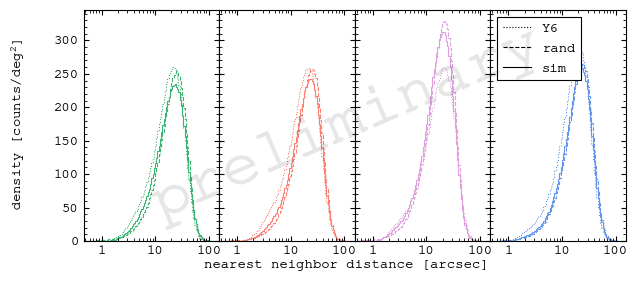

In [64]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    1, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 3),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    axs[tomographic_bin].stairs(
        hist_y6[tomographic_bin],
        bins,
        ec=tomo_colors[tomographic_bin],
        ls=":",
        label="Y6",
    )
    axs[tomographic_bin].stairs(
        hist_rand[tomographic_bin],
        bins,
        ec=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    axs[tomographic_bin].stairs(
        hist_sim[tomographic_bin],
        bins,
        ec=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    # axs[tomographic_bin].legend(loc="upper left")

axs[0].set_xscale("log")
axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].set_ylim(0, None)

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("density [$counts / deg^2$]")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[3].legend(lines, labels, loc="upper left")

watermark(fig)

plt.show()

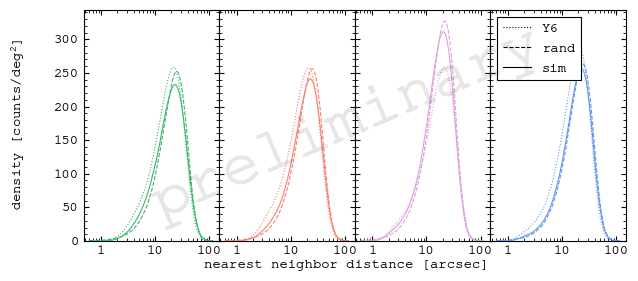

In [65]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    1, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 3),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    contour1d(
        axs[tomographic_bin],
        hist_y6[tomographic_bin],
        bins,
        c=tomo_colors[tomographic_bin],
        ls=":",
        label="Y6",
    )
    contour1d(
        axs[tomographic_bin],
        hist_rand[tomographic_bin],
        bins,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    contour1d(
        axs[tomographic_bin],
        hist_sim[tomographic_bin],
        bins,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    # axs[tomographic_bin].legend(loc="upper left")

axs[0].set_xscale("log")
axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].set_ylim(0, None)

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("density [$counts / deg^2$]")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[3].legend(lines, labels, loc="upper left")

watermark(fig)

plt.show()

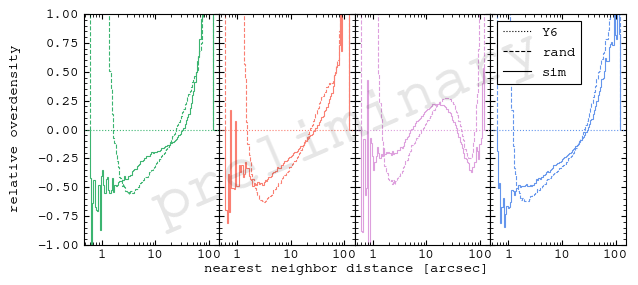

In [66]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    1, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 3),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    axs[tomographic_bin].axhline(
        0,
        c=tomo_colors[tomographic_bin],
        ls=":",
        # label="Y6",
    )
    axs[tomographic_bin].stairs(
        hist_rand[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        ec=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    axs[tomographic_bin].stairs(
        hist_sim[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        ec=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    # axs[tomographic_bin].legend(loc="upper left")

axs[0].set_xscale("log")
axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].set_ylim(-1, 1)

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("relative overdensity")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[3].legend(lines, labels, loc="upper left")

watermark(fig)

plt.show()

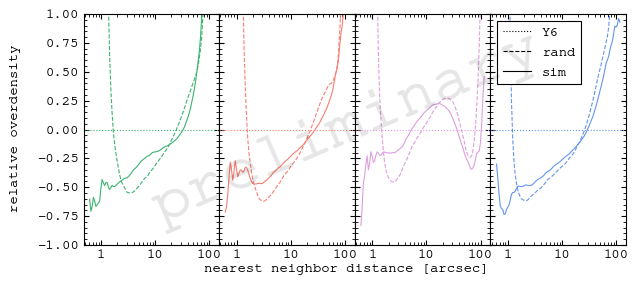

In [67]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    1, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 3),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    axs[tomographic_bin].axhline(
        0,
        c=tomo_colors[tomographic_bin],
        ls=":",
        # label="Y6",
    )
    contour1d(
        axs[tomographic_bin],
        hist_rand[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    contour1d(
        axs[tomographic_bin],
        hist_sim[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    # axs[tomographic_bin].legend(loc="upper left")

axs[0].set_xscale("log")
axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].set_ylim(-1, 1)

fig.supxlabel("nearest neighbor distance [arcsec]")
fig.supylabel("relative overdensity")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[3].legend(lines, labels, loc="upper left")

watermark(fig)

plt.show()

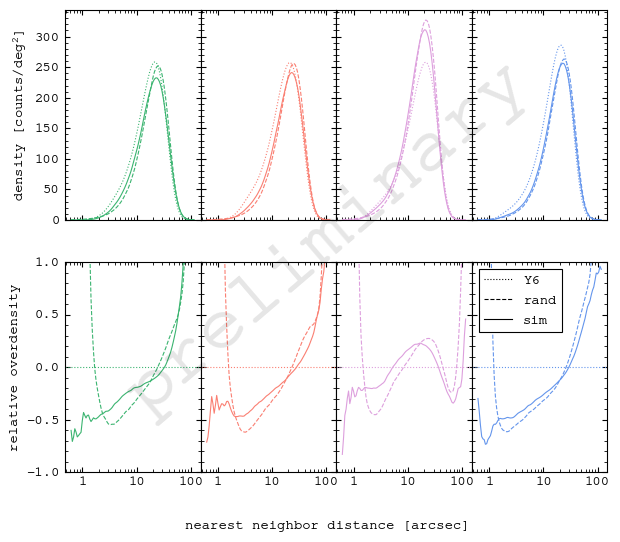

In [68]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(
    2, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 6),
    sharex=True,
    sharey="row",
)
fig.subplots_adjust(wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    contour1d(
        axs[0, tomographic_bin],
        hist_y6[tomographic_bin],
        bins,
        c=tomo_colors[tomographic_bin],
        ls=":",
        label="Y6",
    )
    contour1d(
        axs[0, tomographic_bin],
        hist_rand[tomographic_bin],
        bins,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    contour1d(
        axs[0, tomographic_bin],
        hist_sim[tomographic_bin],
        bins,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )

    axs[1, tomographic_bin].axhline(
        0,
        c=tomo_colors[tomographic_bin],
        ls=":",
        # label="Y6",
    )
    contour1d(
        axs[1, tomographic_bin],
        hist_rand[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        c=tomo_colors[tomographic_bin],
        ls="--",
        label="rand",
    )
    contour1d(
        axs[1, tomographic_bin],
        hist_sim[tomographic_bin] / hist_y6[tomographic_bin] - 1,
        bins,
        c=tomo_colors[tomographic_bin],
        ls="-",
        label="sim",
    )
    
# axs[0, 0].legend(loc="upper left")
# axs[1, 0].legend(loc="upper left")

axs[0, 0].set_xscale("log")
axs[0, 0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0, 0].set_ylim(0, None)

axs[1, 0].set_ylim(-1, 1)

fig.supxlabel("nearest neighbor distance [arcsec]")

axs[0, 0].set_ylabel("density [$counts / deg^2$]")
axs[1, 0].set_ylabel("relative overdensity")

lines = [
    mpl.lines.Line2D([0], [0], color="k", linestyle=ls)
    for ls in [":", "--", "-"]
]
labels = ["Y6", "rand", "sim"]
axs[1, 3].legend(lines, labels, loc="upper left")

watermark(fig)

fig.savefig("tomographic-clustering.pdf")

plt.show()

In [73]:
with h5py.File("clustering.hdf5", "w") as hf:
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
        tomo_group = hf.create_group(f"bin{tomographic_bin}")
        for group in ["Y6", "rand", "sim"]:
            data_group = tomo_group.create_group(group)
            data_group.create_dataset("density", data=hist_sim[tomographic_bin])
            data_group.create_dataset("bins", data=bins)